In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,GlobalAveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as Up_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive/')

import tensorflow
print(tensorflow.__version__)
!pip install tensorflow==1.15.3
!pip install tqdm
import tqdm
!pip install Pillow
!pip install typing-utils
!pip install SimpleITK

import SimpleITK as sitk
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import typing_utils

import scipy.misc
import cv2

##import SimpleITK as sitk

from PIL import Image

#from scipy.misc import imread

%matplotlib inline
from IPython.display import clear_output
pd.options.mode.chained_assignment = None

Mounted at /content/gdrive/
2.7.0
     |████████████████████████████████| 110.5 MB 21 kB/s 
     |████████████████████████████████| 503 kB 30.0 MB/s 
     |████████████████████████████████| 3.8 MB 26.1 MB/s 
     |████████████████████████████████| 50 kB 4.7 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=d2cafc1da686ea33faa6c5d45c4154a41001822cad07bfb77af2c0c457a4b16e
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uni

     |████████████████████████████████| 48.4 MB 3.0 MB/s 


In [ ]:
import h5py

In [ ]:
# Load HDF5 dataset

h5f = h5py.File('/content/gdrive/MyDrive/Class_Lung2d/preprocessed_data/Combined_Axialtraindataset_new.h5', 'r')
X_train_images = h5f['X']
Y_train_labels = h5f['Y']

h5f2 = h5py.File('/content/gdrive/MyDrive/Class_Lung2d/preprocessed_data/Combined_Axialvaldataset_new.h5', 'r')
X_val_images = h5f2['X']
Y_val_labels = h5f2['Y']



Converting to training dataset

In [ ]:
X_train_images_np = np.expand_dims(np.array(X_train_images), axis = 3)
y_train_labels_np = np.array(Y_train_labels)
X_val_images_np = np.expand_dims(np.array(X_val_images), axis = 3)
y_val_labels_np = np.array(Y_val_labels)

In [ ]:
print(X_train_images_np.shape)
print(y_train_labels_np.shape)
print(X_val_images_np.shape)
print(y_val_labels_np.shape)



(1914, 128, 128, 1)
(1914, 4)
(639, 128, 128, 1)
(639, 4)


processing for test dataset

In [ ]:
h5f2 = h5py.File('/content/gdrive/MyDrive/Class_Lung2d/preprocessed_data/Combined_Axialtestdataset_new.h5', 'r')
X_test_images = h5f2['X']
Y_test_labels = h5f2['Y']

In [ ]:
X_test_images_np = np.expand_dims(np.array(X_test_images), axis = 3)
y_test_labels_np = np.array(Y_test_labels)
print(X_test_images_np.shape)
print(y_test_labels_np.shape)


(639, 128, 128, 1)
(639, 4)


In [ ]:
image_size = 128
print("\nTrain Batches: ")
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,zoom_range=0.1)
train_batches = datagen.flow(X_train_images_np, y_train_labels_np, batch_size=64)

print("\nTest Batches: ")
#test_batches = datagen.flow(X_val_images_np, y_val_labels_np, batch_size=64)



Train Batches: 

Test Batches: 


Model Making


In [ ]:
#Soft Attention

from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x


        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC

        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]

        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape


        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))


        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1)
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)


        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))

            x_exp = K.expand_dims(x,axis=-2)

            u = kl.Multiply()([exp_softmax_alpha, x_exp])

            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u

        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape):
        return [self.out_features_shape, self.out_attention_maps_shape]


    def get_config(self):
        return super(SoftAttention,self).get_config()

In [ ]:
input_layer = Input(shape=(128, 128 ,1),name='input_layer')

conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',) (input_layer)
bn1   = BatchNormalization() (conv1)

conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same') (bn1)
bn2   = BatchNormalization() (conv2)
pool2 = MaxPooling2D((2, 2)) (bn2)
drop2 = Dropout(0.1) (pool2)

conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',) (drop2)
bn3   = BatchNormalization() (conv3)

conv4 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same') (bn3)
bn4   = BatchNormalization() (conv4)
pool4 = MaxPooling2D((2, 2)) (bn4)
drop4 = Dropout(0.2) (pool4)

conv5 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',) (drop4)
bn5   = BatchNormalization() (conv5)

conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same') (bn5)
bn6   = BatchNormalization() (conv6)
pool6 = MaxPooling2D((2, 2)) (bn6)
drop6 = Dropout(0.3) (pool6)

conv7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',) (drop6)
bn7   = BatchNormalization() (conv7)

conv8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same') (bn7)
bn8   = BatchNormalization() (conv8)
pool8 = MaxPooling2D((2, 2)) (bn8)
drop8 = Dropout(0.3) (pool8)

conv9 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',) (drop8)



In [ ]:
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv9.shape[-1]),name='soft_attention')(conv9)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))

conv10 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',) (attention_layer)
bn10   = BatchNormalization() (conv10)

conv11 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same') (bn10)


In [ ]:
output = GlobalAveragePooling2D()(conv11)
#output = BatchNormalization(output)
#output = MaxPooling2D((2,2))(output)
#output = Flatten()(output)
output = Dense(128, activation='relu', kernel_initializer='he_uniform')(output)
#output = BatchNormalization(output)
output = Dense(4, activation='softmax')(output)
model = Model(inputs=input_layer, outputs=output)



In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0     

In [ ]:
opt1=tf.keras.optimizers.Adam(lr=0.0003)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])
checkpoint=  ModelCheckpoint(filepath = 'DFinals.h5',monitor='val_accuracy',save_best_only=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
class_weights = {
                    0: 1.0,
                    1: 2.50,  # bcc
                    2: 1.0,  # bkl
                    3: 1.14,  # df

                }

In [ ]:
Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=35, min_delta=0.001)
steps = int(X_train_images_np.shape[0] / 64)
history = model.fit(train_batches,
                    steps_per_epoch=steps,
                    epochs=120,
                    verbose=1,
                    validation_data=(X_val_images_np, y_val_labels_np),callbacks=[checkpoint,Earlystop],class_weight=class_weights)

Epoch 1/120
29/29 [==============================] - 29s 476ms/step - loss: 1.4392 - accuracy: 0.4476 - val_loss: 1.3423 - val_accuracy: 0.1753
Epoch 2/120
29/29 [==============================] - 7s 235ms/step - loss: 1.2496 - accuracy: 0.5314 - val_loss: 1.4812 - val_accuracy: 0.1534
Epoch 3/120
29/29 [==============================] - 7s 255ms/step - loss: 1.1705 - accuracy: 0.5643 - val_loss: 1.3418 - val_accuracy: 0.1596
Epoch 4/120
29/29 [==============================] - 7s 235ms/step - loss: 1.1016 - accuracy: 0.6076 - val_loss: 1.4097 - val_accuracy: 0.1534
Epoch 5/120
29/29 [==============================] - 7s 234ms/step - loss: 1.0640 - accuracy: 0.6049 - val_loss: 1.5056 - val_accuracy: 0.1534
Epoch 6/120
29/29 [==============================] - 8s 257ms/step - loss: 0.9876 - accuracy: 0.6486 - val_loss: 1.5534 - val_accuracy: 0.1534
Epoch 7/120
29/29 [==============================] - 7s 233ms/step - loss: 0.9375 - accuracy: 0.6714 - val_loss: 1.6392 - val_accuracy: 0.175

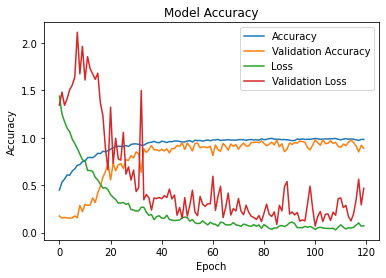

In [ ]:
# plot diagnostic learning curves
import matplotlib.pyplot as plt
def summarize_diagnostics(hist):
	plt.plot(hist.history["accuracy"])
	plt.plot(hist.history['val_accuracy'])
	plt.plot(hist.history['loss'])
	plt.plot(hist.history['val_loss'])
	plt.title("Model Accuracy")
	plt.ylabel("Accuracy")
	plt.xlabel("Epoch")
	plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
	plt.savefig('newasd')

summarize_diagnostics(history)

In [ ]:
model.save('/content/gdrive/MyDrive/Class_Lung2d/Thesis.h5')

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

y_pred = model.predict(X_test_images_np)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test_labels_np,axis=1)
print('confusion matrix')
cf_matrix = confusion_matrix(y_true,y_p)


confusion matrix
[[ 84  23   9]
 [ 23 251  13]
 [  6   5 225]]


In [ ]:
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    categories = ['Benign','Primary','Metastatic']
    plt.figure(figsize=figsize)

    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('Actual Class')
        plt.xlabel('Predicted Class' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

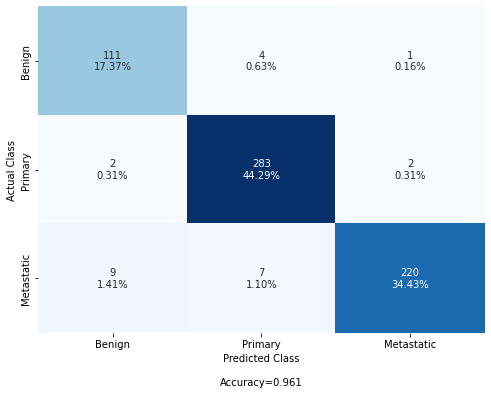

In [ ]:
make_confusion_matrix(cf_matrix, figsize=(8,6), cbar=False)

In [ ]:
print('Full report')
print(classification_report(y_true,y_p))

Full report
              precision    recall  f1-score   support

           1       0.95      0.92      0.93       116
           2       0.97      0.95      0.96       287
           3       0.94      0.98      0.96       236

    accuracy                           0.95       639
   macro avg       0.95      0.95      0.95       639
weighted avg       0.95      0.95      0.95       639



In [ ]:
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
test_batches = datagen.flow(X_test_images_np, y_test_labels_np, batch_size=1,shuffle=False)

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_array, heatmap, alpha=0.4):
    # Load the original image

    #img = (img_array[0] + 1)/2

    # Rescale heatmap to a range 0-255
    #heatmap = np.uint8(255 * heatmap)
    plt.imshow(img_array[0],alpha=1.0)
    plt.imshow(cv2.resize(heatmap,(128,128),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.4)
    plt.show()

    # Display Grad CAM

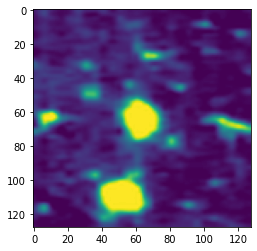

3

In [ ]:
img_size = (128, 128)

img_array= X_test_images_np[500].transpose(2,0,1)
last_conv_layer_name = "conv2d_10"

plt.imshow((img_array[0]))
plt.show()

preds = model.predict(img_array)
np.argmax(preds)

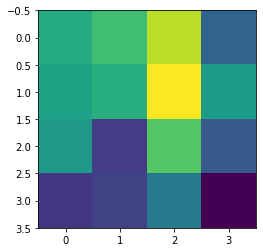

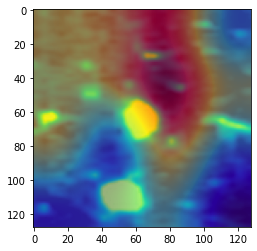

In [ ]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
plt.imshow(heatmap)
plt.show()
save_and_display_gradcam(img_array, heatmap)

In [ ]:
sa_model = Model(model.inputs,model.get_layer('soft_attention').output)
sa_features, sa_maps = sa_model.predict(X_test_images_np)
sa_maps.shape

(639, 16, 8, 8)

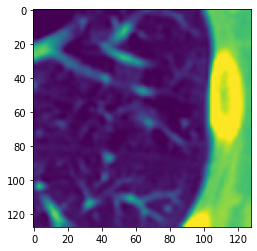

(8, 8)


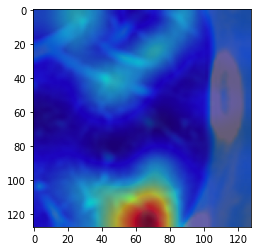

In [ ]:
img_idx = 100
t = X_test_images_np[img_idx].transpose(2,0,1)
t=t[0]

plt.imshow(t)
plt.show()
sum_attnmap = np.sum(sa_maps[img_idx],0)
print(sum_attnmap.shape)
plt.imshow(t,alpha=1.0)
plt.imshow(cv2.resize(sum_attnmap,(128,128),interpolation=cv2.INTER_CUBIC),cmap='jet',alpha=0.6)
plt.show()

In [ ]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(4):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

NameError: ignored

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()